# *P. pacificus* pharynx connectomes

In [1]:
import datetime
import time

import networkx as nx
import pandas as pd
from graspologic.plot import adjplot
from pkg.data import DATA_PATH
from pkg.utils import create_node_data, ensure_connected, select_lateral_nodes

OUT_PATH = DATA_PATH / "processed_split"

t0 = time.time()

## Filter data
Make sure neurons are lateralized and fully connected

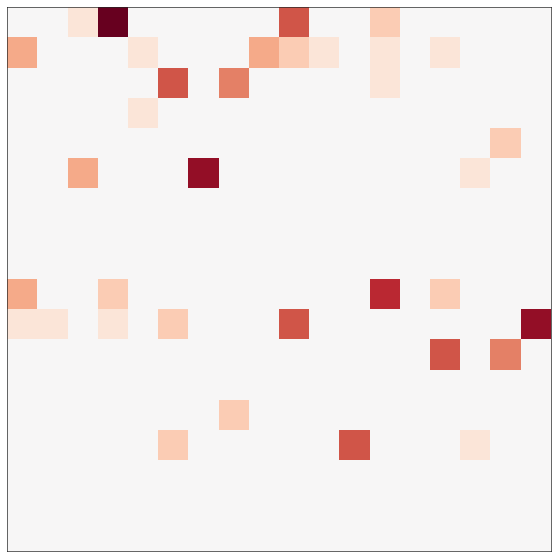

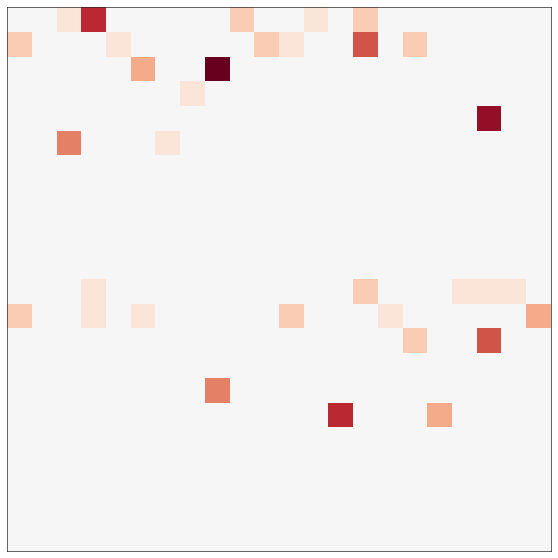

In [2]:
for specimen in ["107", "148"]:
    path = DATA_PATH / "p_pacificus"
    path = path / f"specimen_{specimen}_synapselist.csv"
    mg = nx.read_edgelist(path, create_using=nx.MultiDiGraph, delimiter=",")
    # HACK for weighting by synapse count
    adj_df = nx.to_pandas_adjacency(mg)

    g = nx.from_pandas_adjacency(adj_df, create_using=nx.DiGraph)
    adj_df = nx.to_pandas_adjacency(g)

    adj_df = pd.DataFrame(
        data=adj_df.values.astype(int), index=adj_df.index, columns=adj_df.columns
    )
    nodes = create_node_data(list(g.nodes))
    adj_df = adj_df.reindex(index=nodes.index, columns=nodes.index)

    # get rid of any nodes which don't have a side designation
    adj_df, nodes, removed_nonlateral = select_lateral_nodes(adj_df, nodes)
    # then ensure the network is fully connected
    adj_df, nodes, removed_lcc = ensure_connected(adj_df, nodes)
    # then remove any nodes whose partner got removed by that process
    adj_df, nodes, removed_partner_lcc = select_lateral_nodes(adj_df, nodes)
    # REPEAT in case this removal of partners causes disconnection
    adj_df, nodes, removed_lcc2 = ensure_connected(adj_df, nodes)
    adj_df, nodes, removed_partner_lcc2 = select_lateral_nodes(adj_df, nodes)

    adjplot(adj_df.values, plot_type="heatmap")

    g = nx.from_pandas_adjacency(adj_df, create_using=nx.DiGraph)
    nx.write_edgelist(
        g,
        OUT_PATH / f"specimen_{specimen}_edgelist.csv",
        delimiter=",",
        data=["weight"],
    )

    nodes.to_csv(OUT_PATH / f"specimen_{specimen}_nodes.csv")

## End

In [3]:
elapsed = time.time() - t0
delta = datetime.timedelta(seconds=elapsed)
print(f"Script took {delta}")
print(f"Completed at {datetime.datetime.now()}")

Script took 0:00:00.293497
Completed at 2022-05-13 13:34:11.975156
